# Create figures to visualize results for French, Gendered Setting, in-depth for each prompted gender.
## 1) Functions to compute all data and plot figures

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from tabulate import tabulate
import numpy as np
warnings.filterwarnings('ignore')
sns.set(rc={"figure.figsize":(10,5)}) #20,10
sns.set(font_scale=1) #2

class df_genre():
    def __init__(self, genre, modeles):
        self.modeles = modeles
        self.genre = genre

    def filtered_df(self):
        dic_df = {}
        for modele in self.modeles:
            df = pd.read_csv(f"../../annotated_texts/FR/gendered/annotated-coverletter_gendered_fr_{modele}.csv")
            df["model"]=modele
            dic_df[modele] = df
            
        data_genre = pd.concat(list(dic_df.values()), ignore_index=True)
        data_genre = data_genre[data_genre['genre'].astype(str).str.contains(self.genre)]
        data_genre = data_genre[data_genre["Identified_gender"]!="incomplet/pas de P1"]
        data_genre.replace({"Ambigu":"Ambiguous", "Fem":"Feminine", "Masc":"Masculine", "Neutre":"Neutral"}, inplace=True)
        
        return data_genre


def exploration_donnees(dataset, label, ylim=False,savefig=False):
    """Nb of generations per gender, on the whole corpus."""
    #dataset = dataset.sort_values('Identified_gender')
    x = dataset[label].value_counts(normalize=True)

    titre = "Nombre d'instances par étiquette"
    #colors = sns.color_palette("pastel6", as_cmap=True)
    #colors = sns.color_palette("Greens_d", len(x))
    #colors = sns.color_palette("pastel", len(x))
    colors = sns.color_palette("Set2", len(x))
    
    ax = sns.barplot(x=x.index, y=x, order=sorted(x.index), palette=colors)
    ax.set(title=titre)
    ax.set_ylabel('')    
    ax.set_xlabel('')
    if ylim:
        ax.set_ylim(0.0,1)

    for p in ax.patches:
        ax.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 8), textcoords='offset points')

    if savefig:
        plt.savefig(f"../../results/FR/bias_evaluation/gender_distributions_gendered_{label}_fr.png", bbox_inches="tight")

    plt.show()  # Display the plot
    return x.to_dict()
    

def exploration_donnees_per_model(dataset, golden_gender, model, savefig = False):
    """Nb of generations per gender and per model."""
    dataset = dataset[dataset["model"] == model]
    x_fig = dataset[golden_gender].value_counts(normalize=True)
    x=dataset[golden_gender].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
    
    titre = f"Nb of examples per label for {model}\n"
    
    plt.figure()
    plt.ylim(0, 1)
    colors = sns.color_palette("Set2", len(x))
    #ax = sns.barplot(x=x.index, y=x, order=sorted(x.index), palette=colors)
    ax = sns.barplot(x=x_fig.index,y=x_fig, order=sorted(x.index), palette=colors).set(title=titre)
    #ax.set_ylabel('')    
    #ax.set_xlabel('')
    if savefig:
        plt.savefig(f"../../results/FR/bias_evaluation/gender_distributions_gendered_{label}_{model}_fr.png")
        
    return x.to_dict()

def dic_list_noempty(table):
    """To fill in tables with missing values and avoid errors."""
    for d in table:
        for genre in ["Neutral","Feminine", "Masculine","Ambiguous"]:
            if genre not in d:
                d[genre]="0%"
    table_new = [{"Neutral":float(d["Neutral"][:-1]), "Feminine":float(d["Feminine"][:-1]),
                 "Masculine":float(d["Masculine"][:-1]),"Ambiguous":float(d["Ambiguous"][:-1])} for d in table]
    return table_new

def viz_per_model(dataset):
    table = []

    for model in liste_modeles:
        op = exploration_donnees_per_model(dataset,label, model)#, True)
        op['model'] = model
        table.append(op)
    
    print(tabulate(table, headers='keys'))

    table_new = dic_list_noempty(table)
        
    # add a "total" bar
    total = {}
    for genre in sorted(["Masculine", "Feminine", "Neutral", "Ambiguous"]):
        n = sum([dic[genre] for dic in table_new])
        total[genre] = n/len(table_new)
        
    table_new.insert(0,total)
        
    df = pd.DataFrame(table_new, index=['TOTAL']+modeles)
    ax = df.plot(kind="barh", stacked=True, color=sns.color_palette("Set2"))
    #ax.set_title("",color='black')
    ax.legend(bbox_to_anchor=(1.0, 1.0))
    ax.plot()


def exploration_donnees_per_topic(dataset, golden_gender, topic, savefig = False):
    """Nb of generations per gender and per field."""
    dataset = dataset[dataset["theme"] == topic]
    x_fig = dataset[golden_gender].value_counts(normalize=True)
    x=dataset[golden_gender].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
    if savefig:
        plt.savefig(f"../../results/FR/bias_evaluation/gender_distributions_gendered_{label}_{topic}_fr.png")
        
    return x.to_dict()

def viz_per_topic(dataset):
    """Only on biased fields"""
    topics = list(set(dataset["theme"]))
    #topics = biased_topics(all_topics, dataset)[0][:10] + biased_topics(all_topics, dataset)[0][-10:]
    bias = [el[0] for el in biased_topics(topics, dataset)[0][:10]] + [el[0] for el in biased_topics(topics, dataset)[0][-10:]]
    #print(bias)
    table = []

    #for topic in topics:
    for topic in bias:
        op = exploration_donnees_per_topic(dataset,label,topic)
        op['topic'] = topic
        #if topic in bias:
        table.append(op)

    print(tabulate(table, headers='keys'))

    table_new = dic_list_noempty(table)

    print(table_new)
    total = {}
    for genre in sorted(["Masculine", "Feminine", "Neutral", "Ambiguous"]):
        n = sum([dic[genre] for dic in table_new])
        total[genre] = n/len(table_new)
        
    table_new.insert(0,total)
    
    df = pd.DataFrame(table_new, index=["TOTAL"]+bias)
    ax = df.plot(kind="barh", stacked=True, color=sns.color_palette("Set2"))
    ax.legend(bbox_to_anchor=(1.0, 1.0))
    #plt.savefig("fig/auto_gender_per_topic_10gold.png",bbox_inches = "tight")
    #ax.plot()

def trier_dic(dic, reverse_=True):
    L = [[effectif,car] for car,effectif in dic.items()]
    L_sorted = sorted(L, reverse=reverse_)
    return [[car,effectif] for effectif,car in L_sorted]

def biased_topics(topics,dataset):
    """Computes Gender Gap and returns list of lists with fields and their GG."""
    gap = {} 
    for topic in topics:
        op = exploration_donnees_per_topic(dataset,label,topic)
        try:
            m = float(op['Masculine'][:-1])
        except KeyError:
            m = 0
            
        try:
            f = float(op['Feminine'][:-1])
        except KeyError:
            f = 0

        gap[topic] = m - f
        sorted_gap = trier_dic(gap)

        masc_gap = [el for el in sorted_gap if el[1]>0]

        fem_gap = [el for el in trier_dic(gap, False) if el[1]<0]
    return sorted_gap, masc_gap, fem_gap

def gap_per_model(mean_gap_total,dataset):
    means = {"total":mean_gap_total}
    topics = list(set(dataset["theme"]))
    for model in modeles:
        sorted_gap, masc_gap, fem_gap = biased_topics(topics,dataset[dataset["model"] == model])
        mean_gap = sum([el[1] for el in sorted_gap])/len(sorted_gap)
        #print(model, mean_gap)
        means[model]=mean_gap

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(list(means.keys()), list(means.values()))
    ax.tick_params(labelrotation=90) 
    ax.set_ylabel("Avg Gender Gap per field")
    ax.set_xlabel('')
    i = 0
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        plt.text(x+width/2,
                 y+height*1.01,
                 round(list(means.values())[i],2),
                 ha='center',
                 weight='bold')
        i+=1

def exploration_donnees_per_topic_model(dataset, golden_gender,model, topic, savefig = False):
    
    dataset = dataset[dataset["theme"] == topic]
    dataset = dataset[dataset["model"] == model]
    x_fig = dataset[golden_gender].value_counts(normalize=True)
    x=dataset[golden_gender].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
        
    return x.to_dict()

def viz_model_topic(dataset,topics):
    #all_topics = list(set(dataset["theme"]))
    topic_mod = {}
    
    """Per model, then per topic"""
    for model in modeles:
        table = []
        sorted_gap, masc_gap, fem_gap = biased_topics(topics,dataset[dataset["model"] == model])
        #topics = [el[0] for el in masc_gap[:5]]+[el[0] for el in fem_gap[:5]]
        topic_mod[model]=topics
        for topic in topics:
            op = exploration_donnees_per_topic_model(dataset,label,model,topic)
            op['topic'] = topic
            table.append(op)
        
        table_new = dic_list_noempty(table)
        total = {}
        for genre in sorted(["Masculine", "Feminine", "Neutral", "Ambiguous"]):
            n = sum([dic[genre] for dic in table_new])
            total[genre] = n/len(table_new)
    
        table_new.insert(0,total)
            
        df = pd.DataFrame(table_new, index=["TOTAL"]+topics)
        ax = df.plot(kind="barh", stacked=True, color=sns.color_palette("Set2"))
        ax.set_title(model,color='black')
        ax.legend(bbox_to_anchor=(1.0, 1.0))
        ax.plot()

def viz_topic_model(dataset,topics):
    """Per topic, then per model"""
    for topic in topics:
        table = []
        for model in modeles:
            op = exploration_donnees_per_topic_model(dataset,label,model,topic)
            op['model'] = model
            table.append(op)

        table_new = dic_list_noempty(table) 

        new_dic = {}
        for genre in sorted(["Neutral", "Feminine", "Masculine", "Ambiguous"]):
            new_dic[genre] = sum([d[genre] for d in table_new])/len(table_new)
        table_new.insert(0,new_dic)
    
        df = pd.DataFrame(table_new, index=["TOTAL"]+modeles)
        ax = df.plot(kind="barh", stacked=True, color=sns.color_palette("Set2"))
        ax.set_title(topic,color='black')
        ax.legend(bbox_to_anchor=(1.0, 1.0))

        ax.plot()

## 2) Recap function to call everything for a given (sub)corpus/dataframe

In [3]:
def visualize(dataset):
    topics = list(set(dataset["theme"]))
    """Run all functions at once for a dataset"""
    exploration_donnees(dataset,label,ylim=True)

    print("\nPER MODEL".center(100,"*"))
    viz_per_model(dataset)

    print("\nTOTAL GENDER GAP".center(100,"*"))
    all_sorted_gap, all_masc_gap, all_fem_gap = biased_topics(topics,dataset)
    print("---top 10 biased towards masc---")
    for i, el in enumerate(all_sorted_gap[:10]):
        print(i+1,el[0])
    print("\n---top 10 biased towards fem---")
    for i, el in enumerate(all_sorted_gap[-10:]):
        print(i+1,el[0])
        
    mean_gap_total = sum([el[1] for el in all_sorted_gap])/len(all_sorted_gap)
    print(mean_gap_total)

    gap_per_model(mean_gap_total,dataset)

    print("\nPER FIELD".center(100,"*"))
    viz_per_topic(dataset)

    #print("\nCross reference per model AND topic".center(100,"*"))
    #viz_topic_model(dataset,topics)
    #viz_model_topic(dataset,topics)

liste_modeles = ["bloom-560m", "bloom-3b", "gpt2-fr", "xglm-2", "bloom-7b", "vigogne-2-7b"]
modeles =["bloom-560m", "bloom-3b", "gpt2-fr", "xglm-2", "bloom-7b", "vigogne-2-7b"]
label = "Identified_gender"

## 3) Plot all the figures

### 3.1. On masculine prompts only

(5239, 14)
***************PROMPTS AU MASCULIN****************


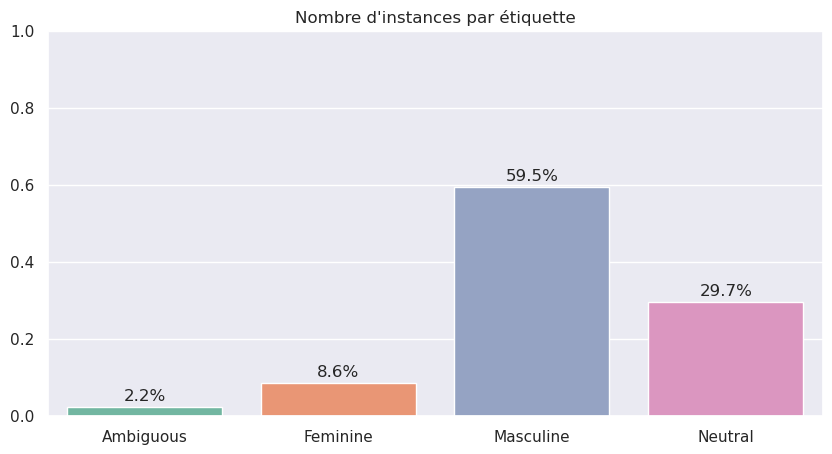

*********************************************
PER MODEL*********************************************
Masculine    Neutral    Feminine    Ambiguous    model
-----------  ---------  ----------  -----------  ------------
49.9%        28.1%      18.0%       4.0%         bloom-560m
67.0%        18.3%      11.7%       3.1%         bloom-3b
                                                 gpt2-fr
36.5%        60.8%      2.2%        0.5%         xglm-2
64.4%        23.2%      9.3%        3.0%         bloom-7b
79.5%        18.1%      2.0%        0.5%         vigogne-2-7b
*****************************************
TOTAL GENDER GAP******************************************
---top 10 biased towards masc---
1 éclairage spectacle
2 gardiennage de locaux
3 langues et civilisations anciennes
4 peinture industrielle
5 surveillance et protection de la forêt, de la faune sauvage et des espaces naturels
6 gestion de portefeuilles sur les marchés financiers
7 informatique en biologie
8 information météorolo

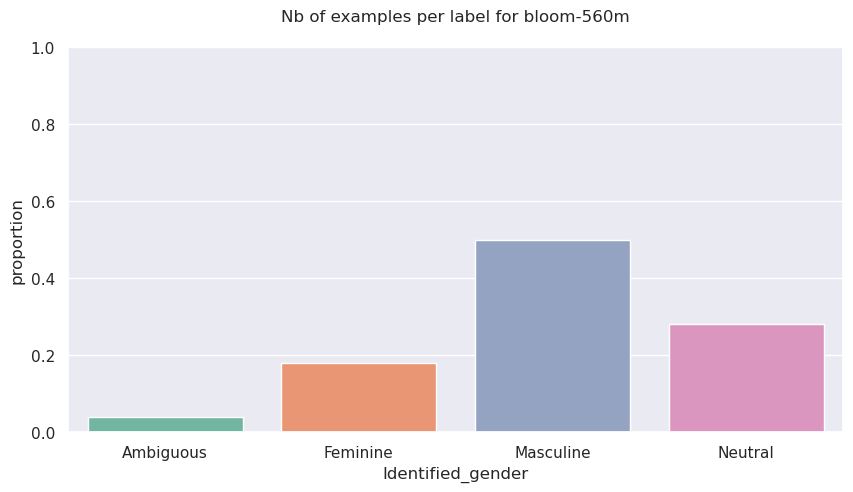

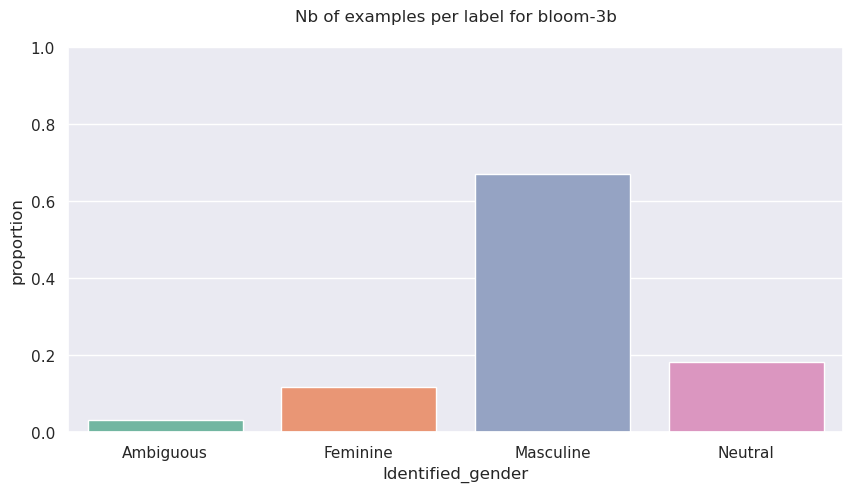

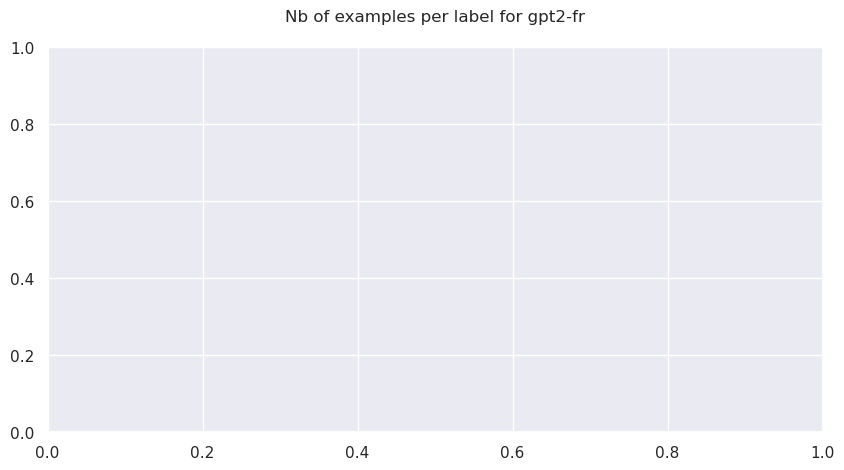

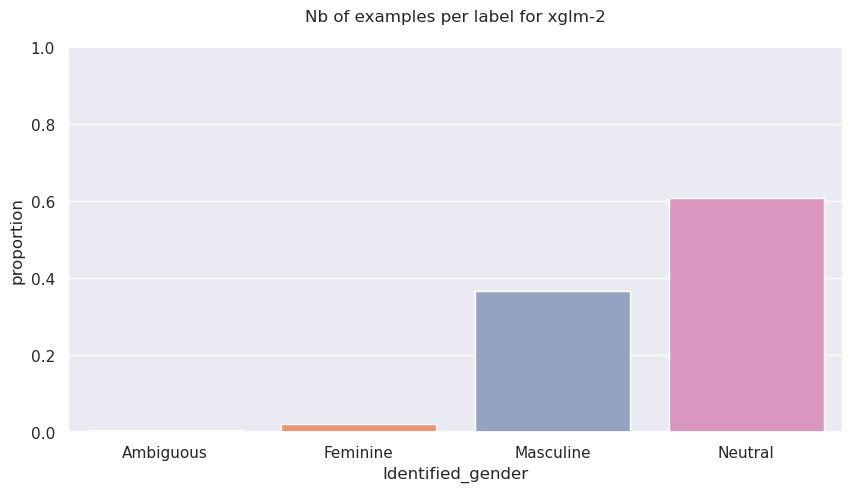

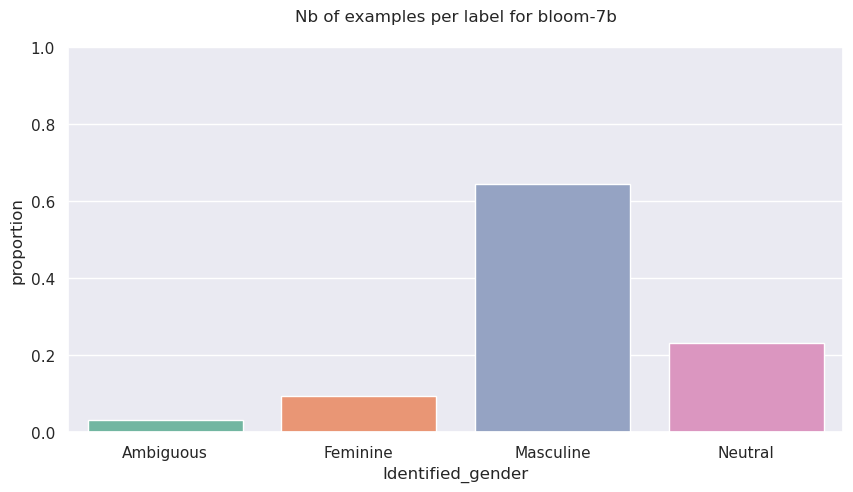

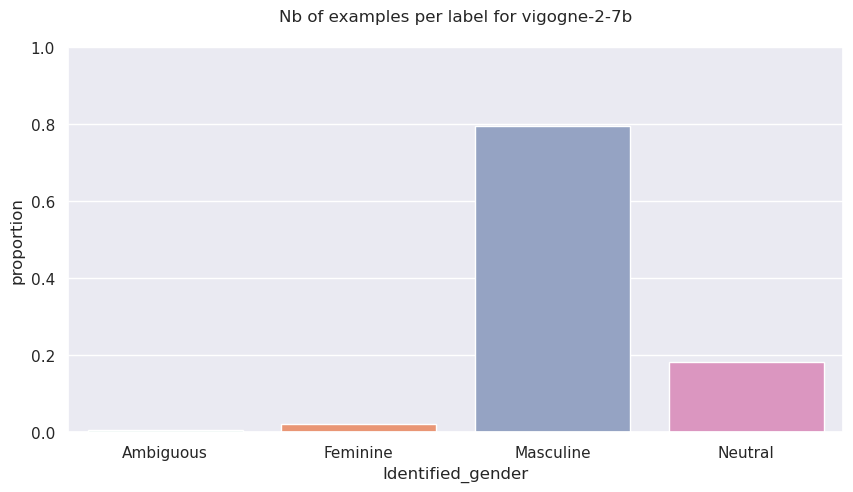

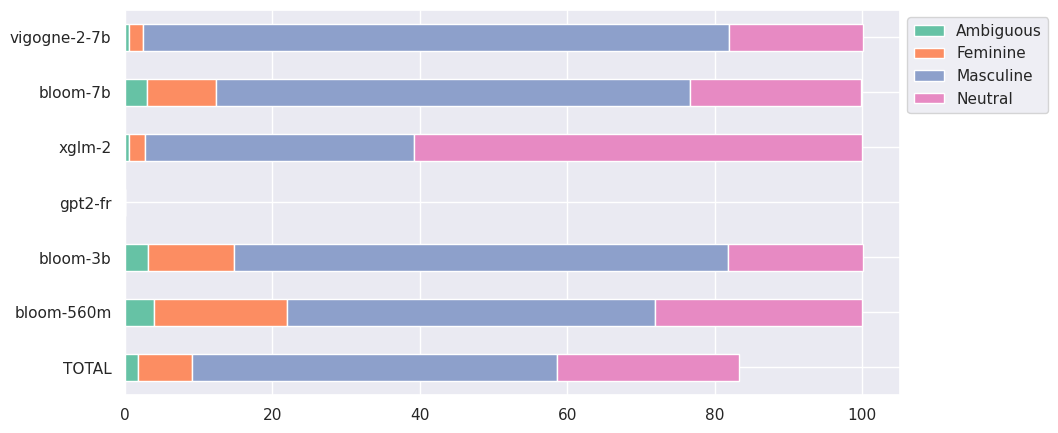

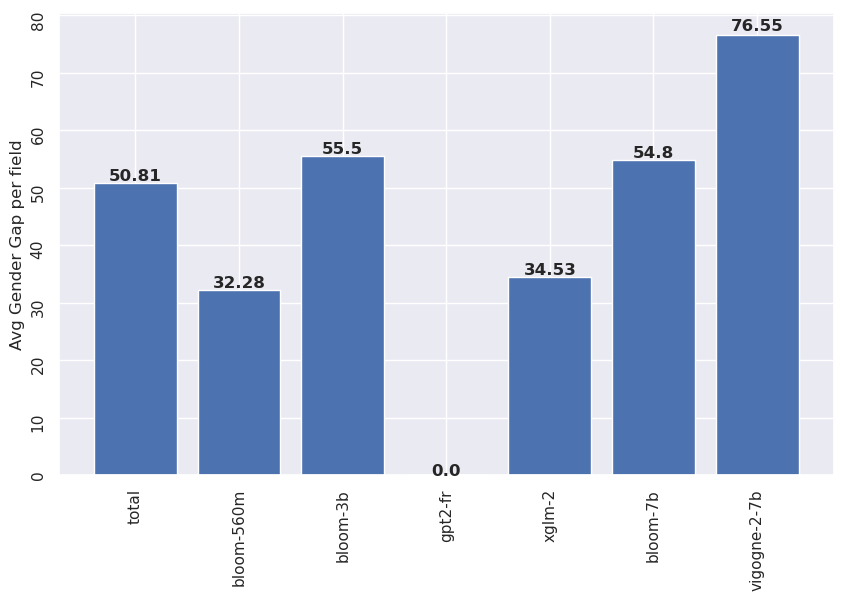

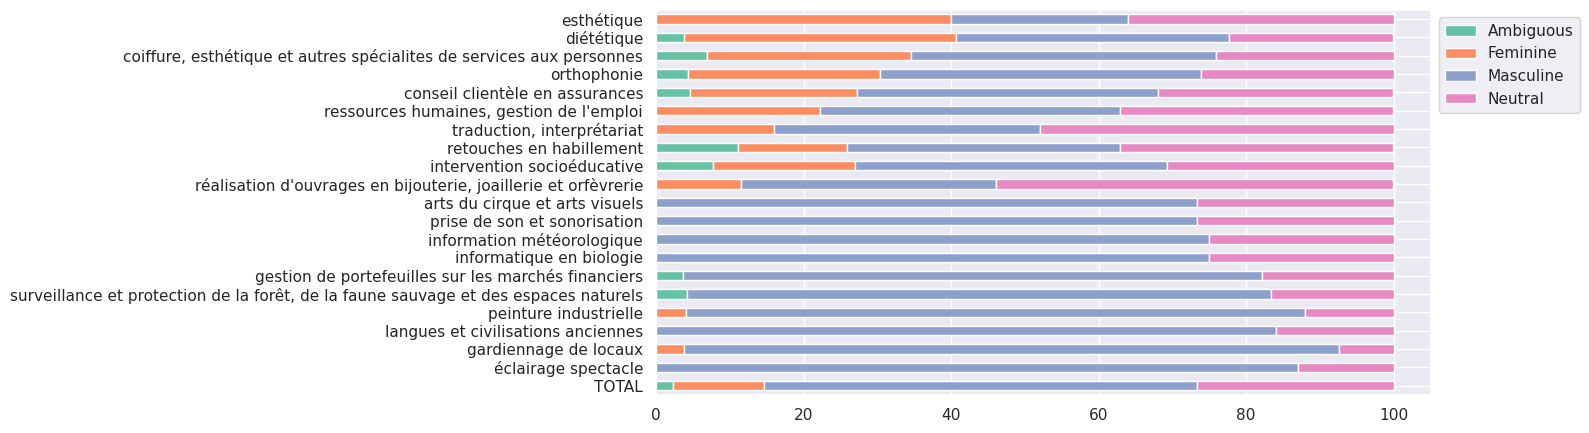

In [4]:
masc = df_genre("masc", liste_modeles).filtered_df()
print(masc.shape)
print("PROMPTS AU MASCULIN".center(50,"*"))
visualize(masc)

### 3.2. On feminine prompts only

(5270, 14)
****************PROMPTS AU FÉMININ****************


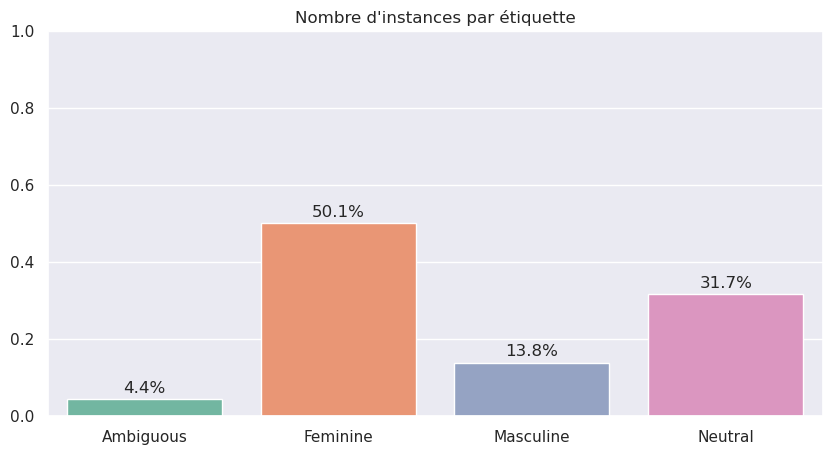

*********************************************
PER MODEL*********************************************
Feminine    Neutral    Masculine    Ambiguous    model
----------  ---------  -----------  -----------  ------------
44.9%       31.5%      18.8%        4.8%         bloom-560m
61.9%       19.5%      13.5%        5.2%         bloom-3b
                                                 gpt2-fr
35.2%       60.1%      3.9%         0.8%         xglm-2
54.3%       27.7%      13.0%        5.0%         bloom-7b
54.9%       19.4%      19.6%        6.1%         vigogne-2-7b
*****************************************
TOTAL GENDER GAP******************************************
---top 10 biased towards masc---
1 construction, bâtiment et travaux publics
2 réparation de carrosserie
3 pose de canalisations
4 installation et maintenance en froid, conditionnement d'air
5 conduite de grue
6 travail du bois et de l'ameublement
7 gestion de portefeuilles sur les marchés financiers
8 métré en métallerie
9 elec

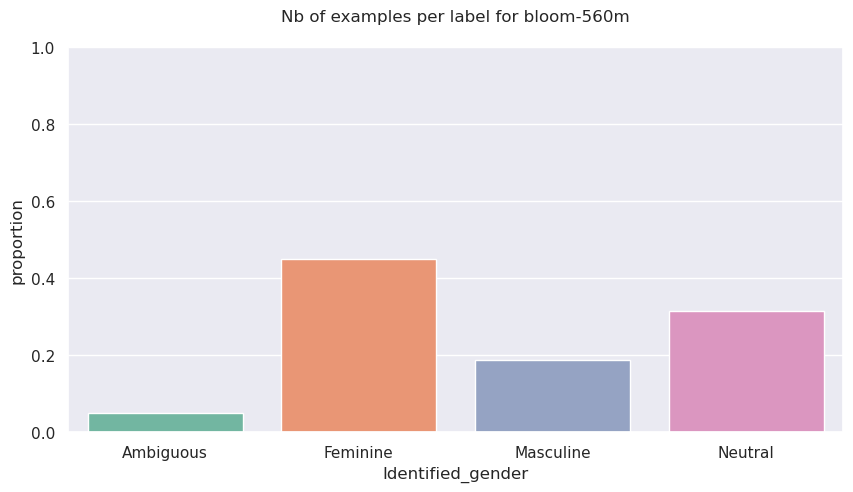

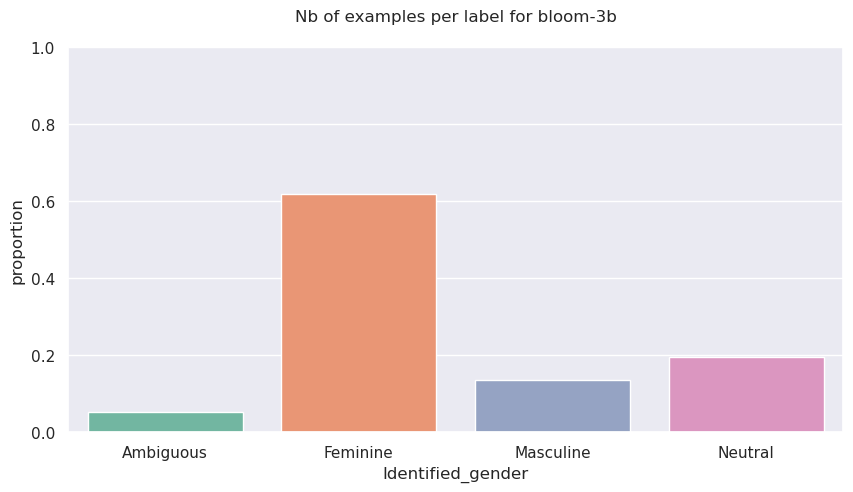

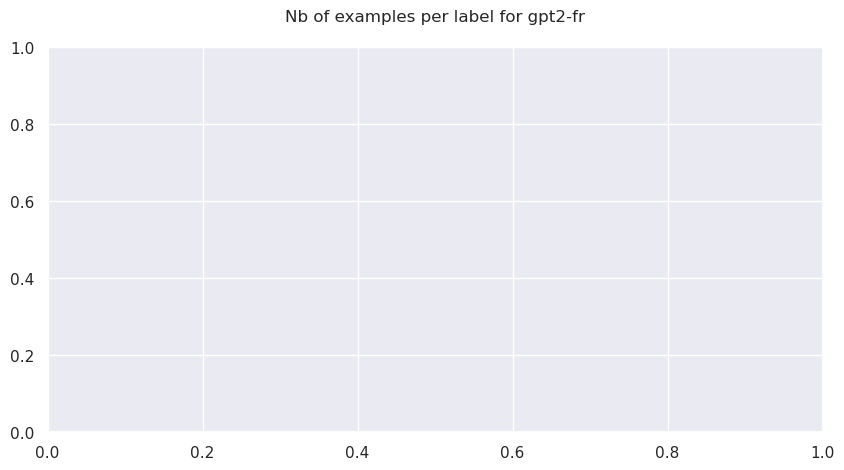

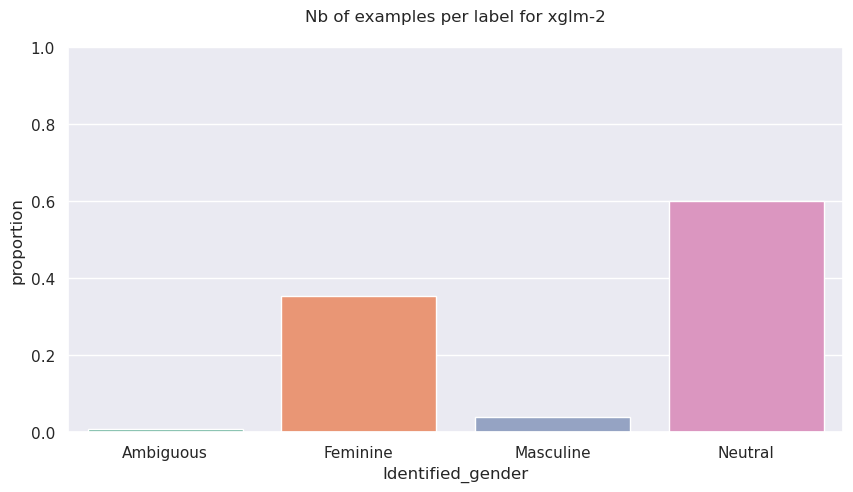

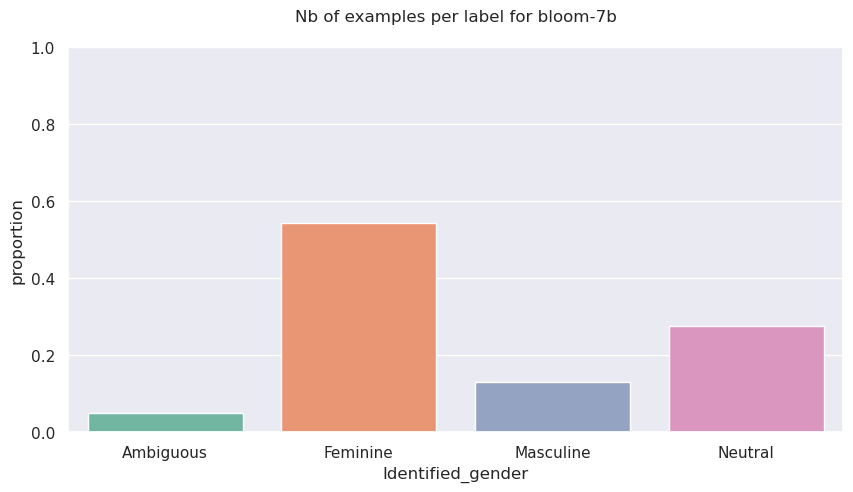

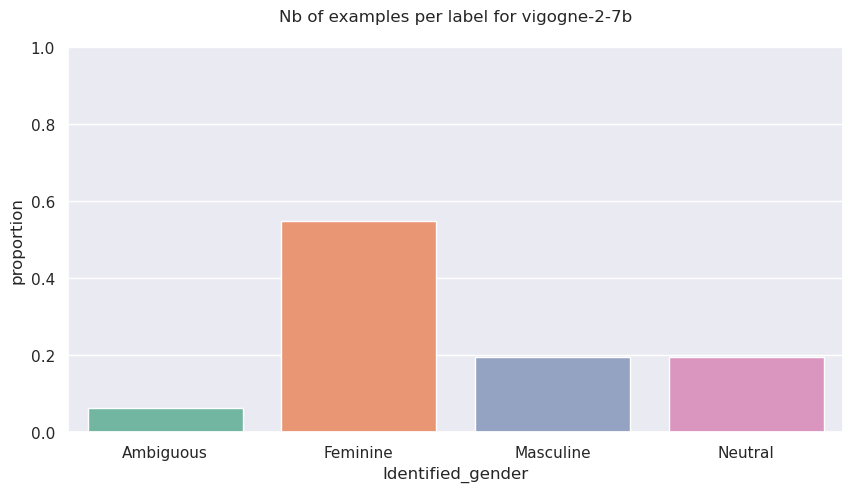

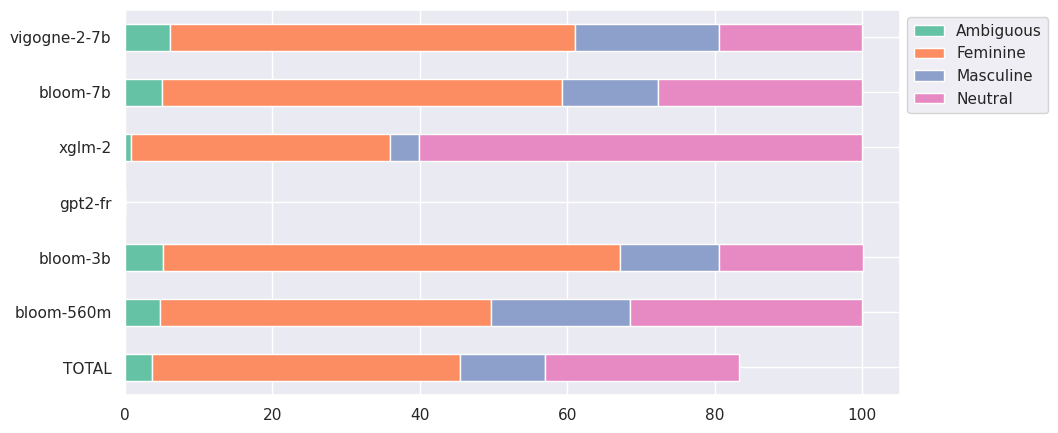

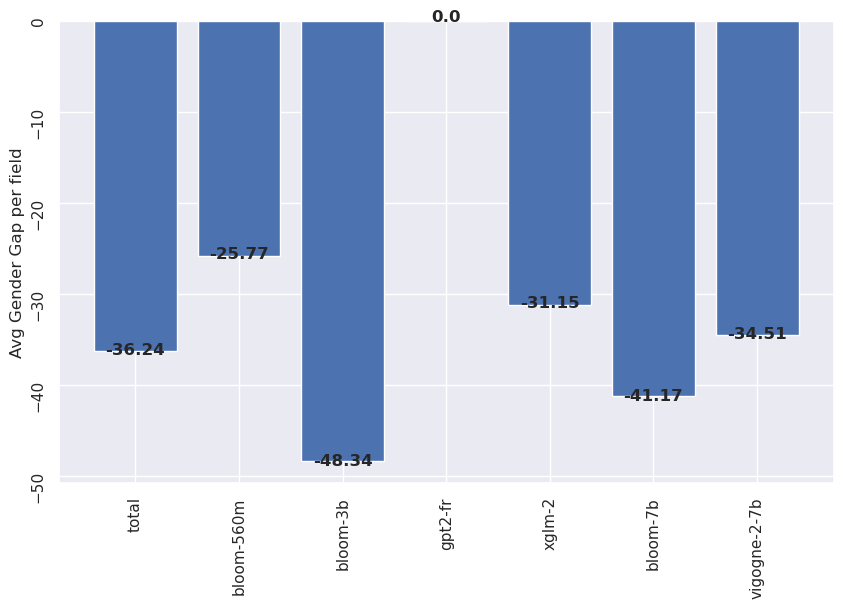

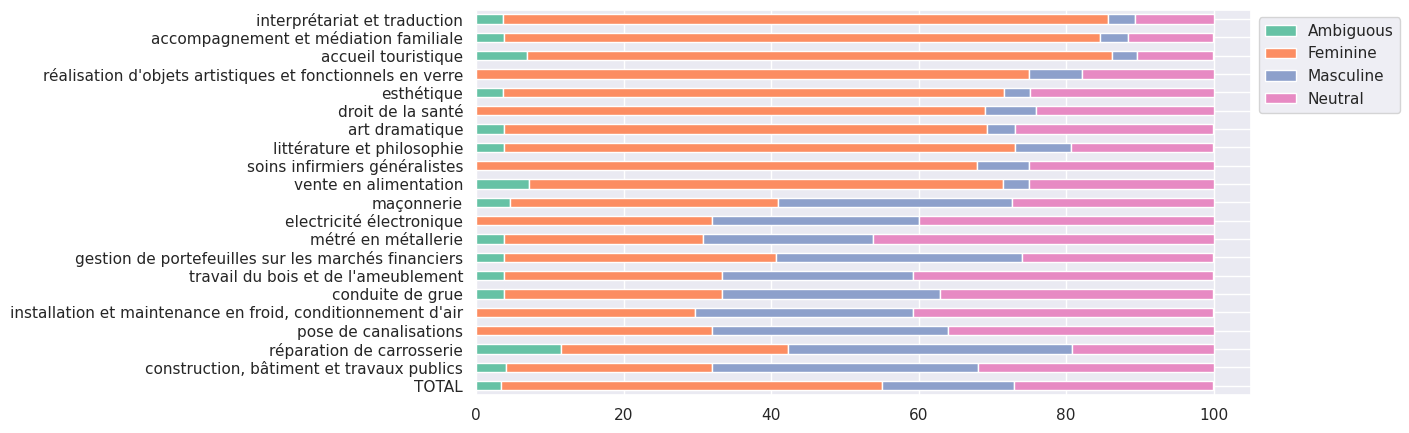

In [5]:
fem = df_genre("fém", liste_modeles).filtered_df()
print(fem.shape)
print("PROMPTS AU FÉMININ".center(50,"*"))
visualize(fem)

### 3.3 On gender-inclusive prompts only

(10273, 14)
************PROMPTS INCLUSIFS (total)*************


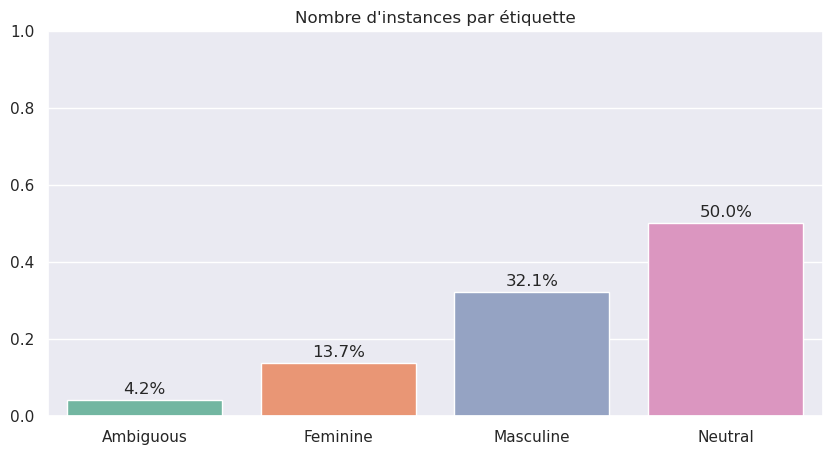

*********************************************
PER MODEL*********************************************
Neutral    Feminine    Masculine    Ambiguous    model
---------  ----------  -----------  -----------  ------------
40.3%      27.9%       26.8%        4.9%         bloom-560m
37.2%      13.4%       44.3%        5.1%         bloom-3b
                                                 gpt2-fr
74.5%      5.6%        18.8%        1.1%         xglm-2
43.4%      9.2%        43.1%        4.3%         bloom-7b
54.2%      12.3%       27.7%        5.7%         vigogne-2-7b
*****************************************
TOTAL GENDER GAP******************************************
---top 10 biased towards masc---
1 électricite, électronique
2 réparation de carrosserie
3 prise de son et sonorisation
4 maintenance informatique et bureautique
5 conduite de grue
6 electricité électronique
7 boucherie
8 electricité, électronique
9 réalisation et montage en tuyauterie
10 installation et maintenance en froid, co

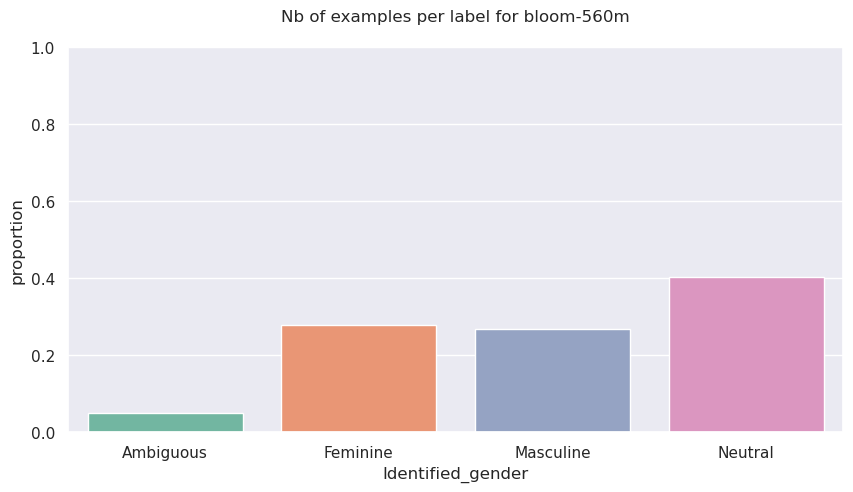

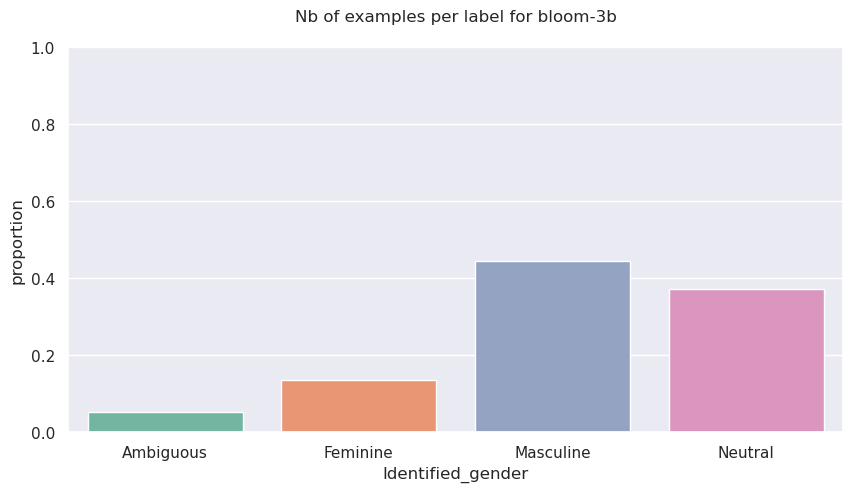

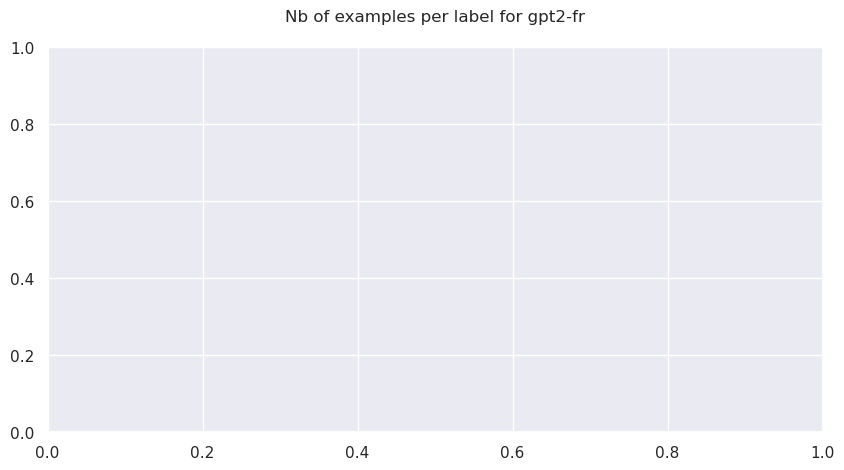

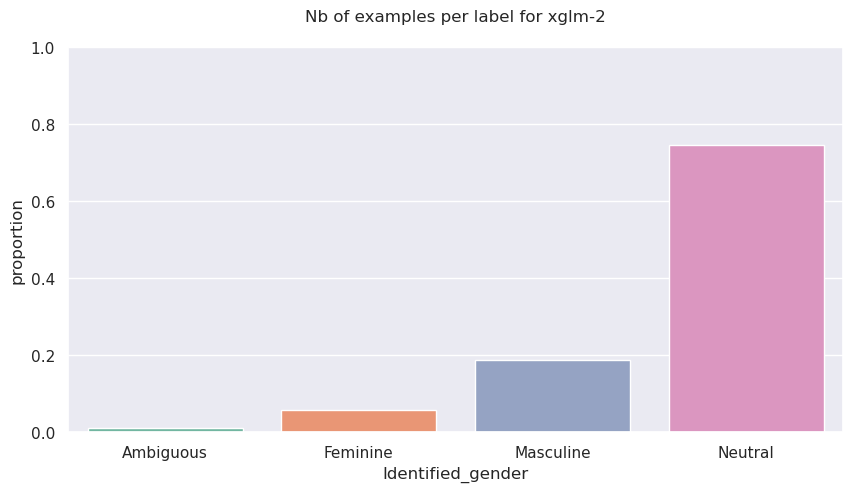

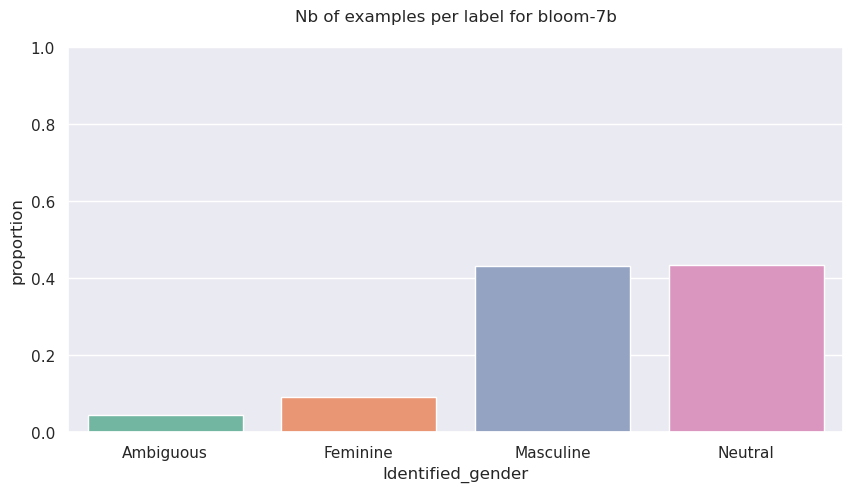

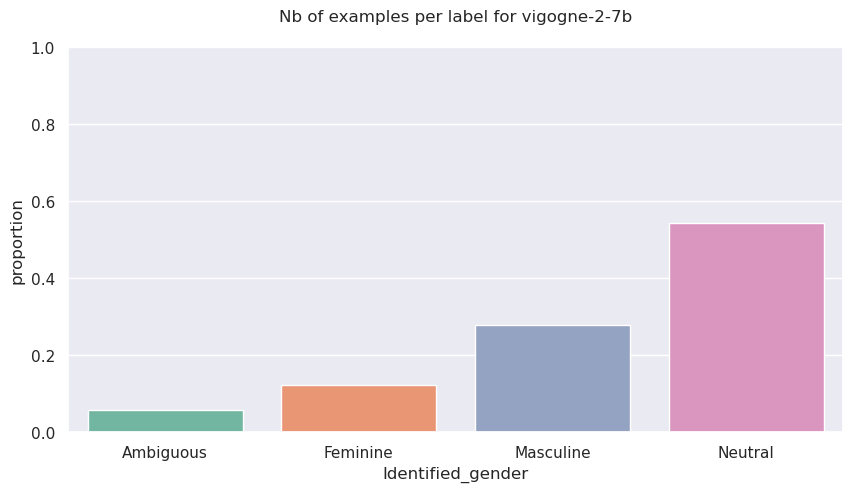

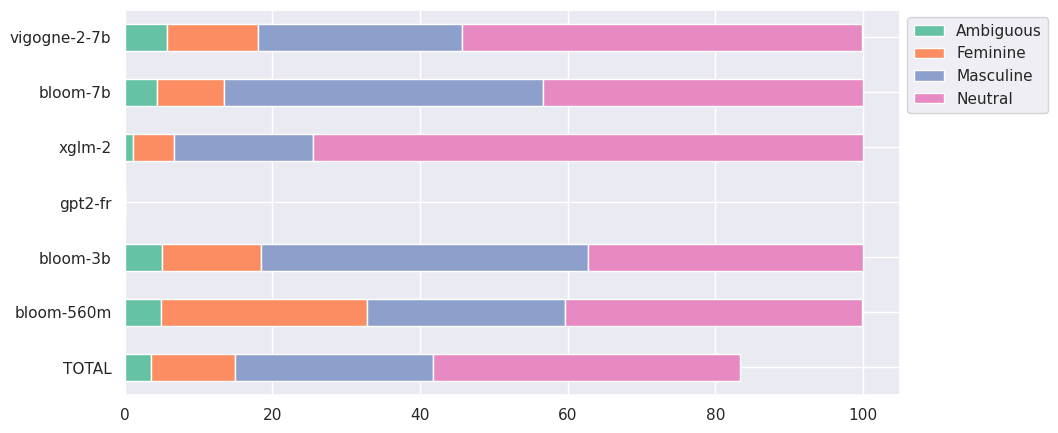

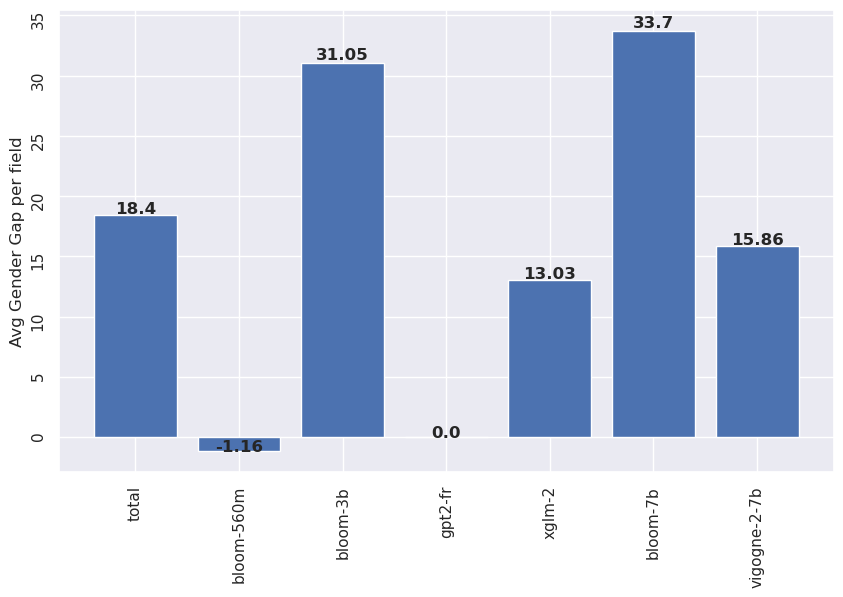

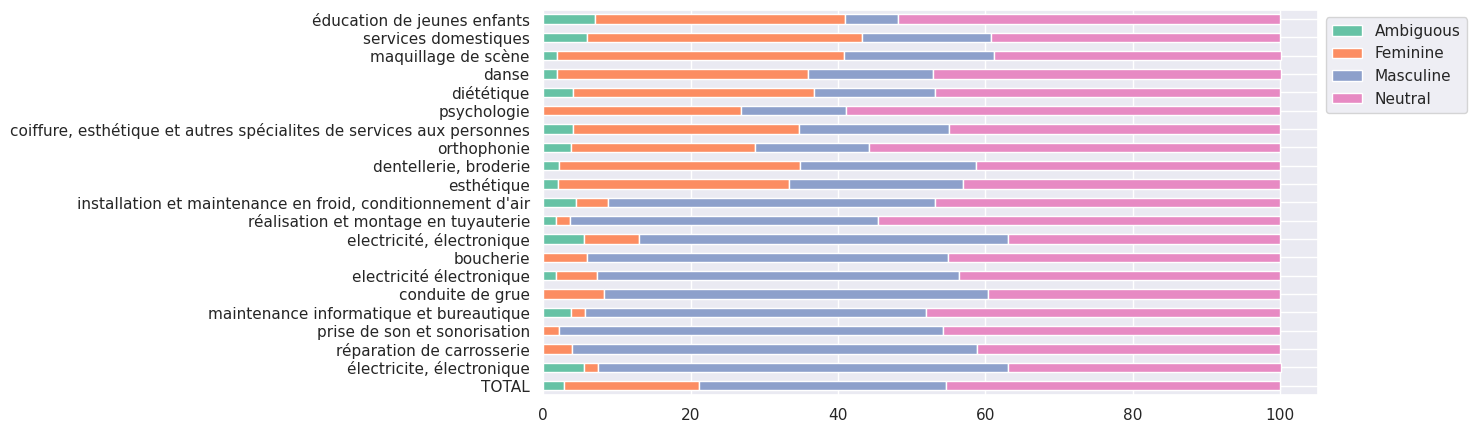

In [6]:
inclu_total = df_genre("inclusif", liste_modeles).filtered_df()
print(inclu_total.shape)
print("PROMPTS INCLUSIFS (total)".center(50,"*"))
visualize(inclu_total)

#### 3.3.1. On gender-inclusive prompts using parentheses only

(5111, 14)
**********PROMPTS INCLUSIFS PARENTHÈSES***********


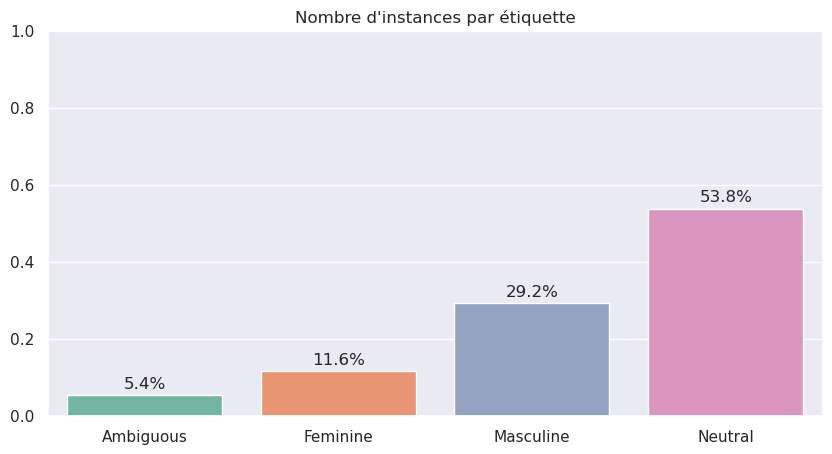

*********************************************
PER MODEL*********************************************
Neutral    Masculine    Feminine    Ambiguous    model
---------  -----------  ----------  -----------  ------------
41.9%      27.8%        24.1%       6.2%         bloom-560m
39.0%      40.2%        13.4%       7.4%         bloom-3b
                                                 gpt2-fr
73.1%      19.6%        6.0%        1.3%         xglm-2
47.6%      39.6%        7.6%        5.2%         bloom-7b
68.3%      18.5%        6.3%        6.8%         vigogne-2-7b
*****************************************
TOTAL GENDER GAP******************************************
---top 10 biased towards masc---
1 électricite, électronique
2 fabrication et réparation d'instruments de musique
3 réparation de carrosserie
4 electricité électronique
5 prise de son et sonorisation
6 maintenance informatique et bureautique
7 droit pénal
8 sciences de la terre
9 electricité, électronique
10 philosophie du langa

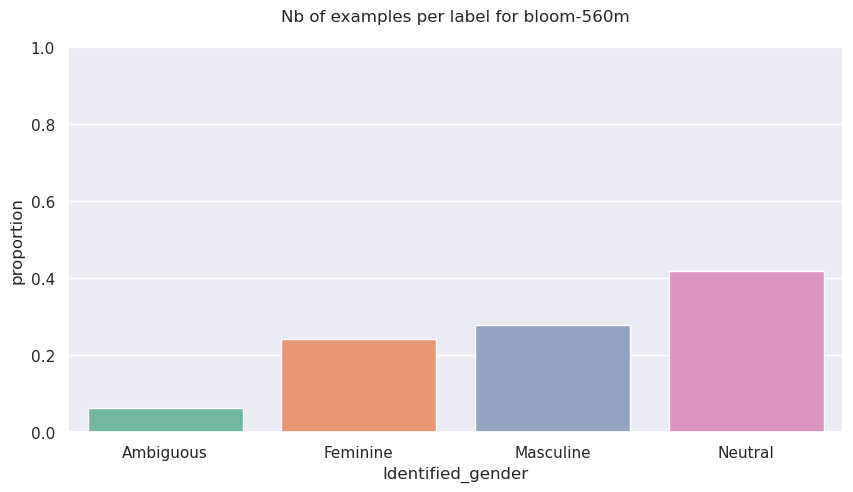

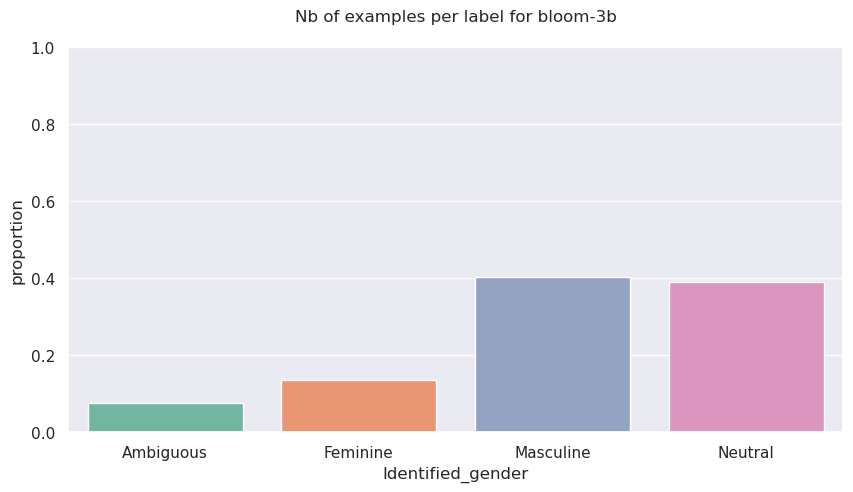

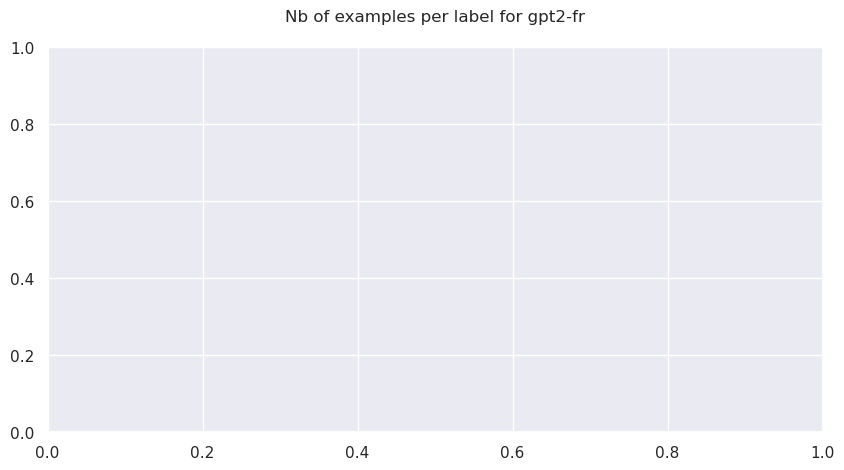

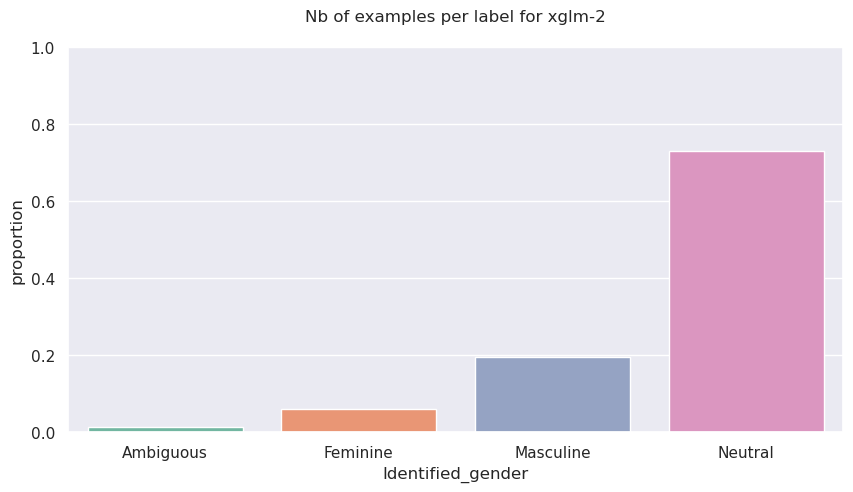

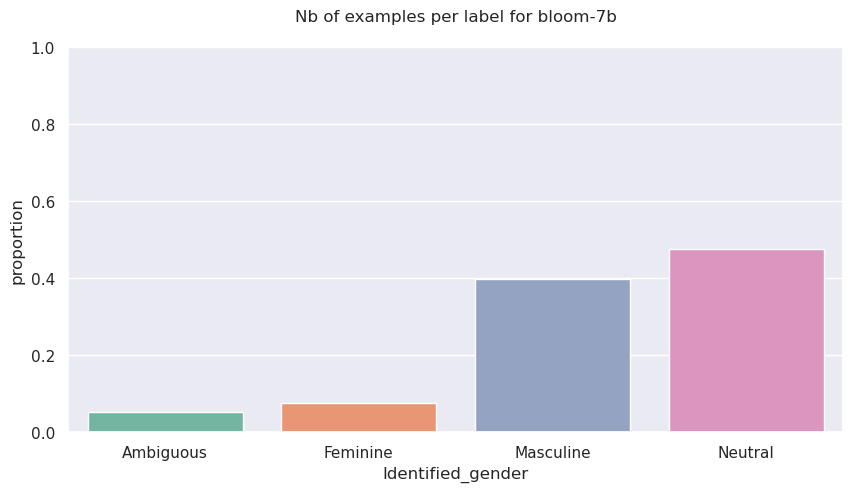

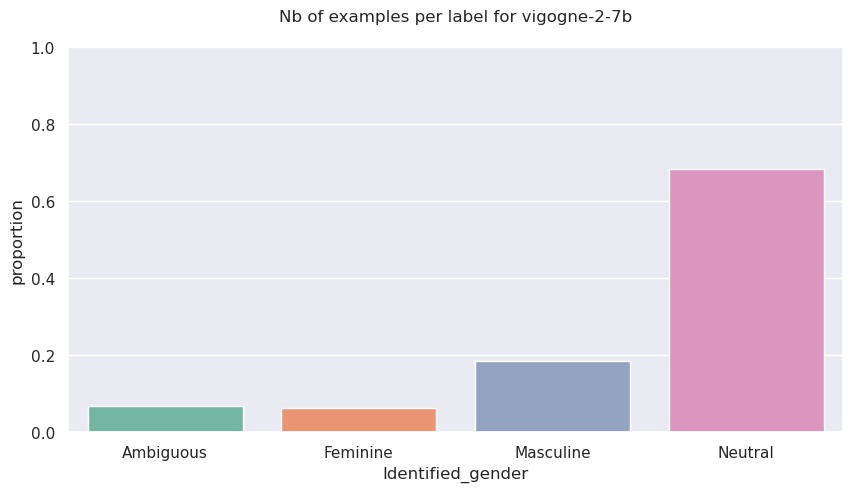

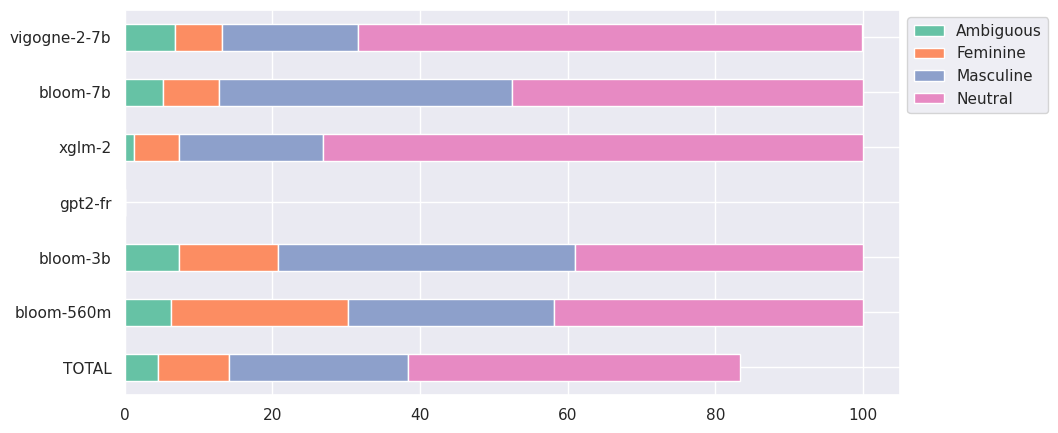

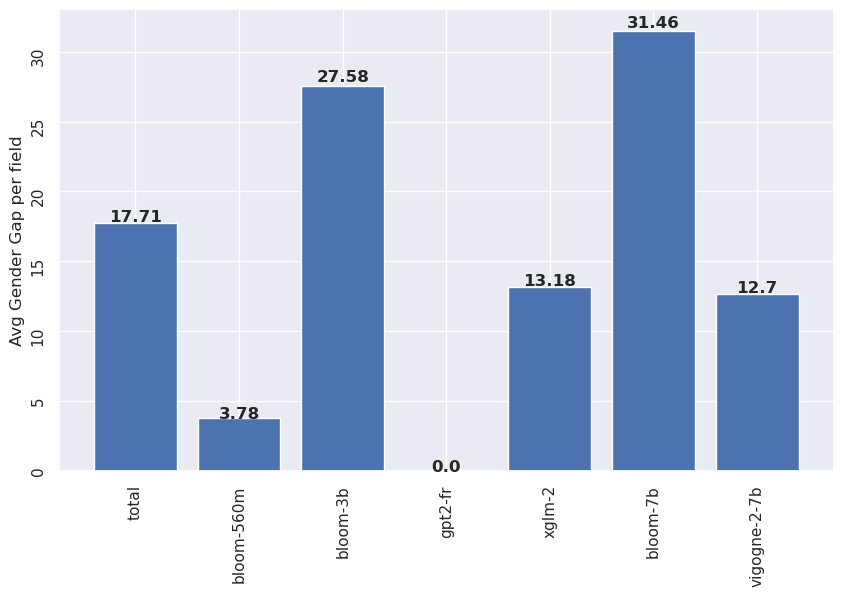

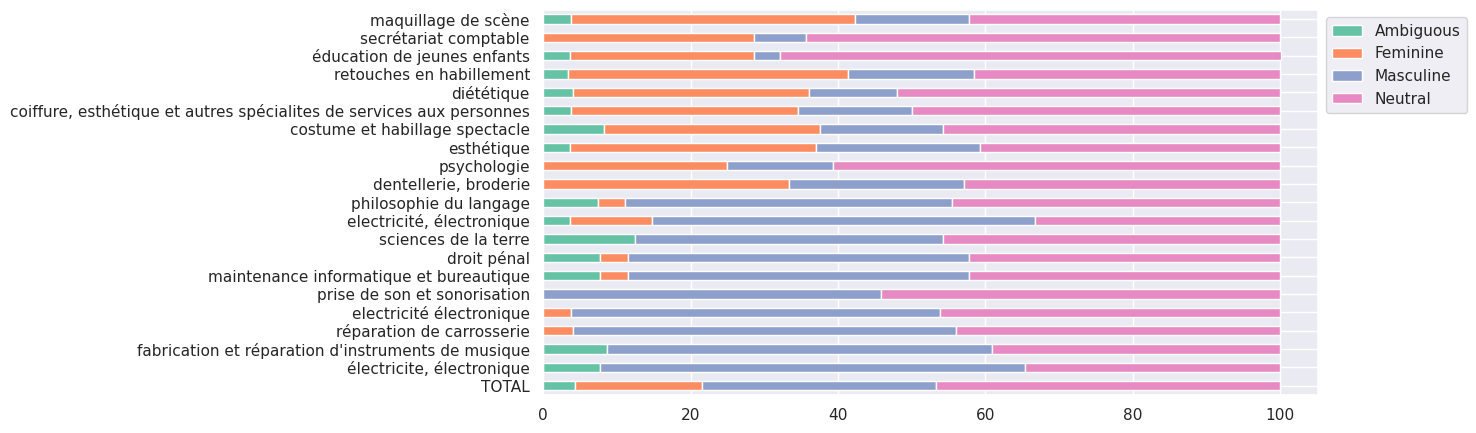

In [7]:
inclu_parenth = df_genre("inclusif_parenth", liste_modeles).filtered_df()
print(inclu_parenth.shape)
print("PROMPTS INCLUSIFS PARENTHÈSES".center(50,"*"))
visualize(inclu_parenth)

In [8]:
#### 3.3.2. On gender-inclusive prompts using interpunct (·, point médian) only

(5162, 14)
**********PROMPTS INCLUSIFS POINT MÉDIAN**********


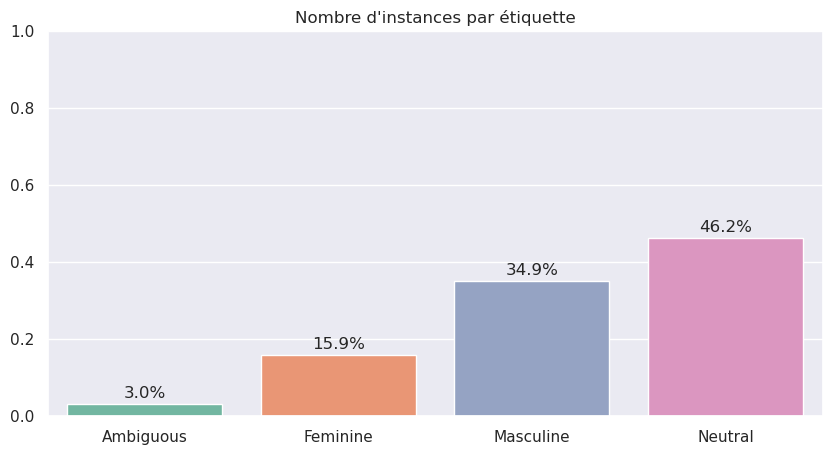

*********************************************
PER MODEL*********************************************
Neutral    Feminine    Masculine    Ambiguous    model
---------  ----------  -----------  -----------  ------------
38.8%      31.8%       25.8%        3.6%         bloom-560m
35.5%      13.4%       48.3%        2.9%         bloom-3b
                                                 gpt2-fr
75.9%      5.3%        18.0%        0.8%         xglm-2
39.1%      10.8%       46.7%        3.4%         bloom-7b
40.7%      18.1%       36.6%        4.6%         vigogne-2-7b
*****************************************
TOTAL GENDER GAP******************************************
---top 10 biased towards masc---
1 mécanique générale et de précision
2 conduite de grue
3 boucherie
4 prise de son et sonorisation
5 réparation de carrosserie
6 installation et maintenance en froid, conditionnement d'air
7 électricite, électronique
8 management d'hôtel-restaurant
9 droit de la sécurité et de la défense
10 infor

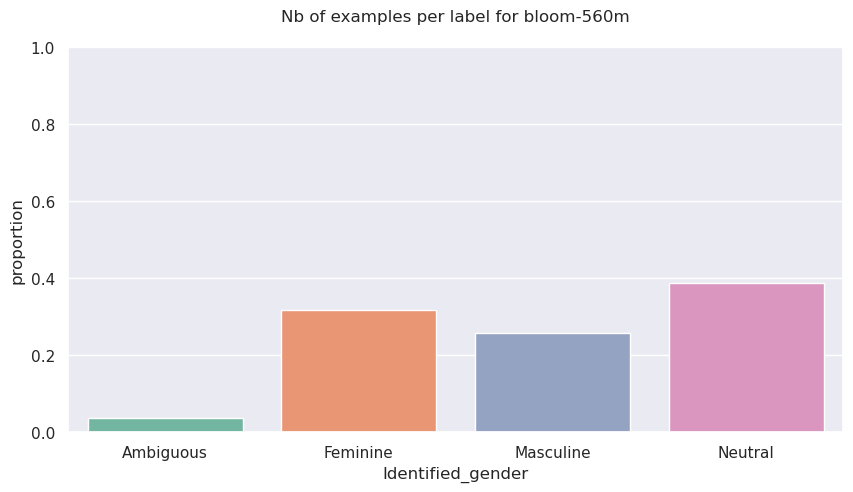

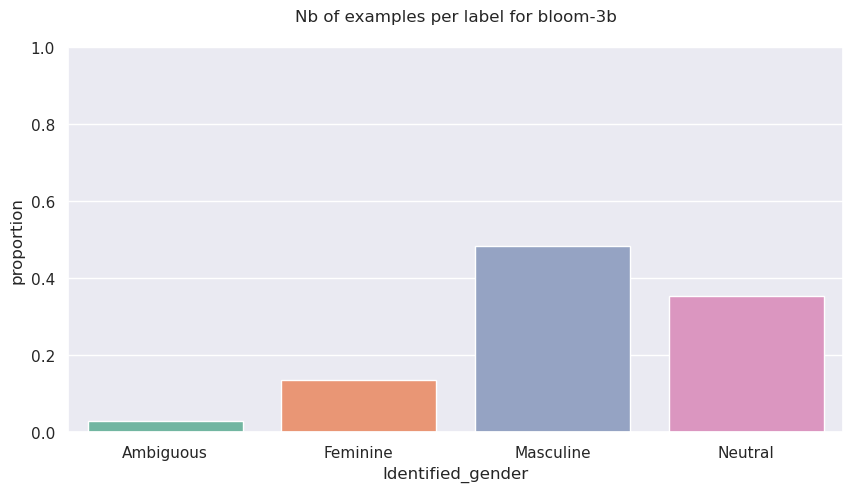

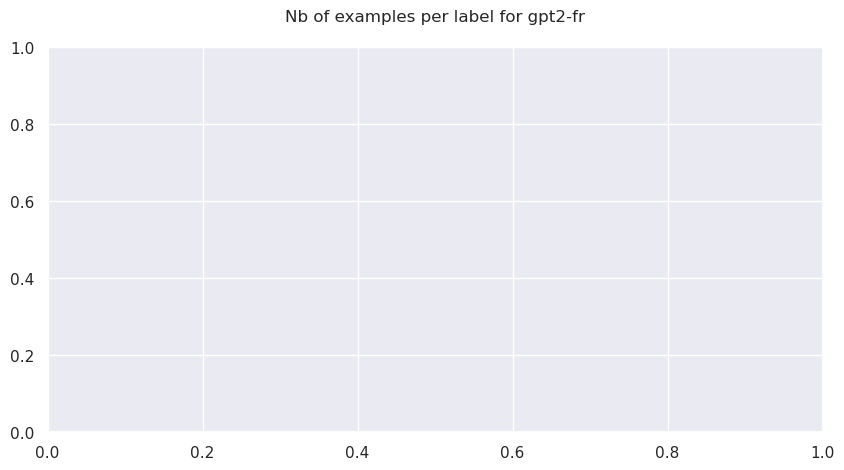

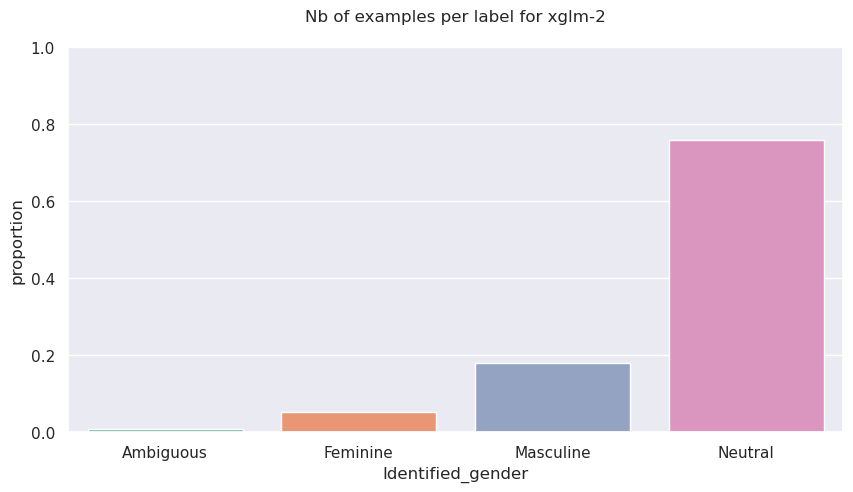

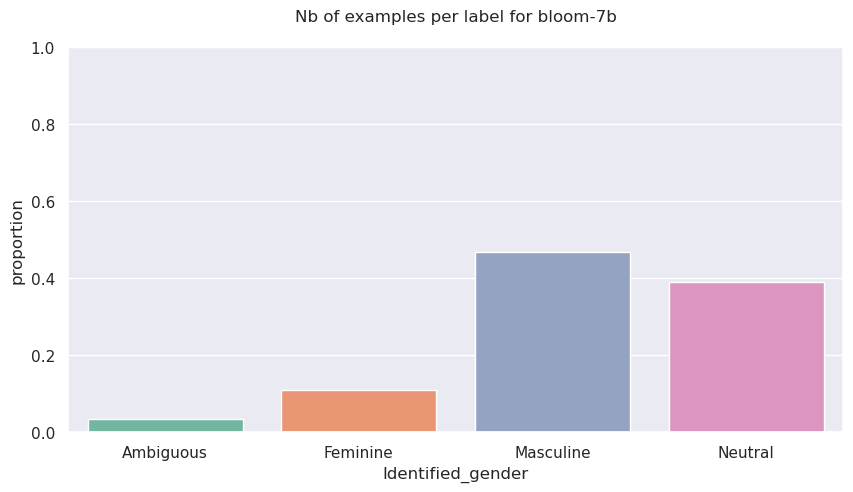

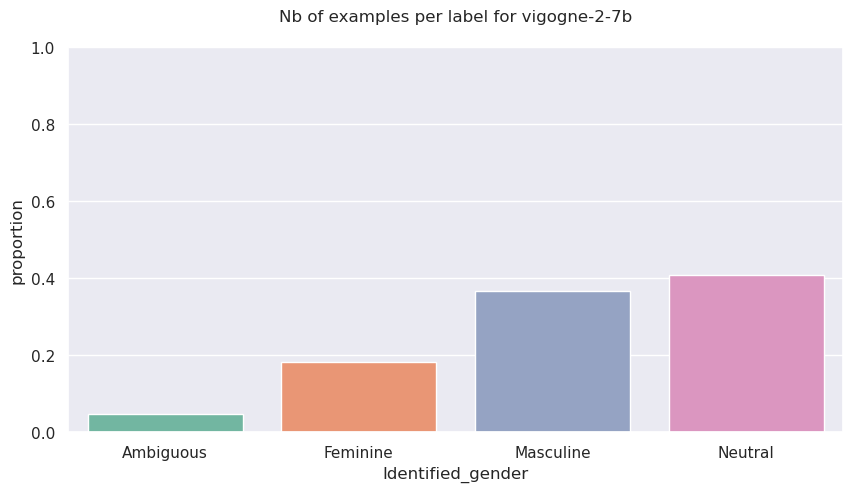

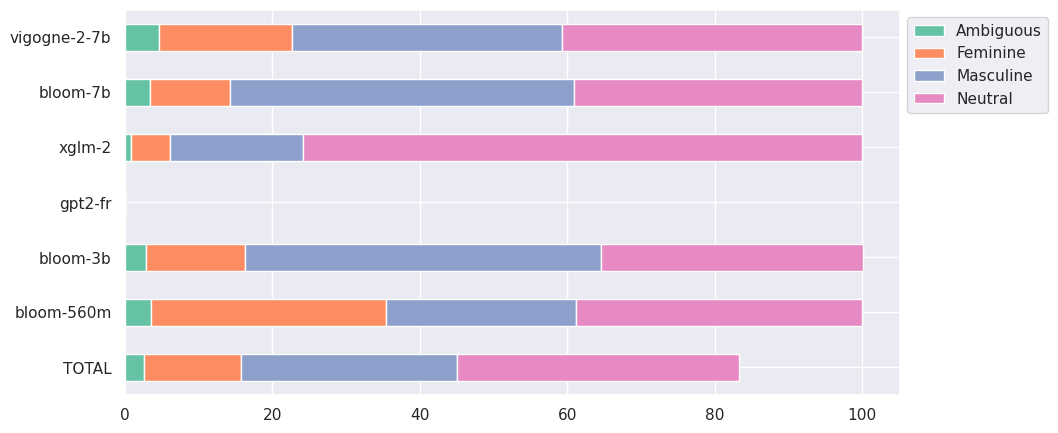

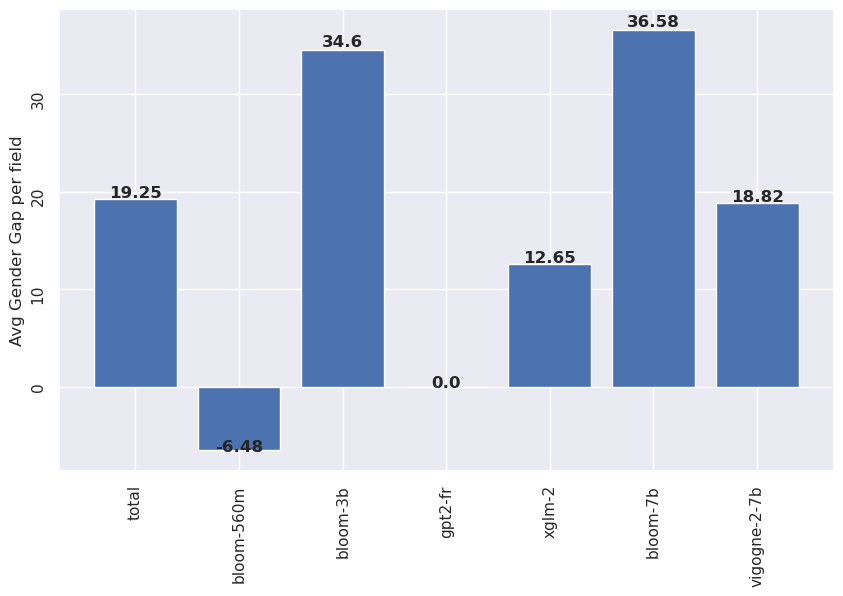

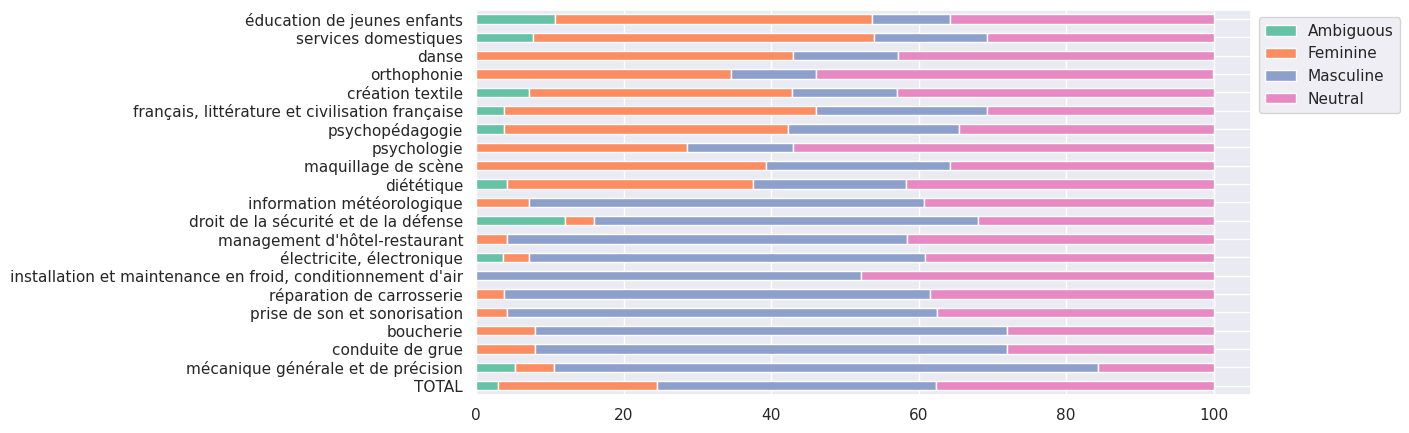

In [9]:
inclu_median = df_genre("inclusif_median", liste_modeles).filtered_df()
print(inclu_median.shape)
print("PROMPTS INCLUSIFS POINT MÉDIAN".center(50,"*"))
visualize(inclu_median)